In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## Unzip dataset (Blender_new)
!mkdir /content/FDA_Drone_Data
!unzip /content/drive/MyDrive/FDA.zip -d /content/FDA_Drone_Data
!rm -rf /content/FDA_Drone_Data/__MACOSX

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/FDA_Drone_Data/FDA/labels_1/image_000577.png  
  inflating: /content/FDA_Drone_Data/FDA/labels_1/image_001669.png  
  inflating: /content/FDA_Drone_Data/FDA/labels_1/image_006106.png  
  inflating: /content/FDA_Drone_Data/FDA/labels_1/image_006660.png  
  inflating: /content/FDA_Drone_Data/FDA/labels_1/image_000211.png  
  inflating: /content/FDA_Drone_Data/FDA/labels_1/image_004077.png  
  inflating: /content/FDA_Drone_Data/FDA/labels_1/image_003718.png  
  inflating: /content/FDA_Drone_Data/FDA/labels_1/image_002406.png  
  inflating: /content/FDA_Drone_Data/FDA/labels_1/image_005369.png  
  inflating: /content/FDA_Drone_Data/FDA/labels_1/image_004063.png  
  inflating: /content/FDA_Drone_Data/FDA/labels_1/image_002412.png  
  inflating: /content/FDA_Drone_Data/FDA/labels_1/image_006674.png  
  inflating: /content/FDA_Drone_Data/FDA/labels_1/image_000205.png  
  inflating: /content/FDA_Drone_Data/FDA/labels_1/image_000563.png  
  infla

In [3]:
from pycocotools.coco import COCO
import os
import os.path as osp
import sys
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
import cv2
import numpy as np
from pycocotools.coco import COCO
from google.colab.patches import cv2_imshow
from torch.utils.data import DataLoader

image = '/content/FDA_Drone_Data/FDA/images'
info_json =  '/content/FDA_Drone_Data/FDA/simulated_corrosion_multi_class_aligned_morph_1.json'

class COCOAnnotationTransform(object):
    def __init__(self):
        self.label_map = COCO_LABEL_MAP

    def __call__(self, target, width, height):
        scale = np.array([width, height, width, height])
        res = []
        for obj in target:
            if 'bbox' in obj:
                bbox = obj['bbox']
                label_idx = self.label_map[obj['category_id']] - 1
                final_box = list(np.array([bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]])/scale)
                final_box.append(label_idx)
                res += [final_box]  # [xmin, ymin, xmax, ymax, label_idx]
            else:
                print("No bbox found for object ", obj)

        return res  # [[xmin, ymin, xmax, ymax, label_idx], ... ]


class COCODetection(data.Dataset):
    def __init__(self, image_path, info_file, transform=None,
                 target_transform=None, has_gt=True):
        self.root = image_path
        self.coco = COCO(info_file)
        self.ids = list(self.coco.imgToAnns.keys())  # 标签数目 小于样本数目，说明有的图像没有标签

        if len(self.ids) == 0 or not has_gt:  # 如果没有标签或者不需要GT，则直接使用image
            self.ids = list(self.coco.imgs.keys())
        self.transform = transform
        self.target_transform = target_transform

        self.has_gt = has_gt

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        im, gt, Mask, h, w, num_crowds, name, Cat = self.pull_item(index)
        return im, (gt, Mask, num_crowds), name, Cat

    def pull_item(self, index):
        img_id = self.ids[index]
        if self.has_gt:
            ann_ids = self.coco.getAnnIds(imgIds=img_id) 
            target = self.coco.loadAnns(ann_ids)
        else:
            target = []
        crowd = [x for x in target if ('iscrowd' in x and x['iscrowd'])] ## iscrowd=0: single target.   iscrowd=1: a group of target(overlapping)
        target = [x for x in target if not ('iscrowd' in x and x['iscrowd'])]
        num_crowds = len(crowd)

        # This is so we ensure that all crowd annotations are at the end of the array
        target += crowd
        file_name = self.coco.loadImgs(img_id)[0]['file_name']
        path = osp.join(self.root, file_name)
        img = cv2.imread(path)
        height, width, _ = img.shape
        if len(target) > 0: # 这样图像中有不是crowd的目标
            Cat = []
            Mask = self.coco.annToMask(target[0]).reshape(-1)
            for obj in target:
              mask = self.coco.annToMask(obj).reshape(-1)
              cat = obj['category_id']

              if cat not in Cat:
                Cat.append(cat)
                Mask = np.vstack((Mask, mask))
              else:
                Mask[-1] = Mask[-1] + mask
              
            Mask = Mask.reshape(-1, height, width)
            Mask = Mask[1:]
        if self.target_transform is not None and len(target) > 0:
            target = self.target_transform(target, width, height)
        return torch.from_numpy(img).permute(2, 0, 1), target, Mask, height, width, num_crowds, file_name, Cat


In [4]:
## Write labeled images
%cd /content/FDA_Drone_Data/FDA
!mkdir ./Label_fromJSON


if __name__=='__main__':
    dataset = COCODetection(image, info_json)
    loader = DataLoader(dataset)
    count = 0
    for img, label, name, Cat in loader:
        img = np.uint8(img.squeeze().numpy().transpose(1, 2, 0))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        Name = name[0].replace('image', 'label')
        gt, masks, num_crowds = label
        masks = masks.squeeze(0) ## .squeeze(A): Delete A_th dimension. Now we left batch * H * w, each batch represent a category labeled by 'pixel==1'
        label_img = np.zeros_like(gray)
        Cat_np = []
        for i in Cat:
          Cat_np.append(i.numpy().reshape(-1))
        for m in range(masks.size(0)):
          mask = masks[m].numpy()
          label_img[np.where(mask==1)] = Cat_np[m][0]
        cv2.imwrite(osp.join('/content/FDA_Drone_Data/FDA/Label_fromJSON', Name), label_img)
        count = count + 1
        print('{}/6171 labels are established'.format(count))

流式输出内容被截断，只能显示最后 5000 行内容。
1172/6171 labels are established
1173/6171 labels are established
1174/6171 labels are established
1175/6171 labels are established
1176/6171 labels are established
1177/6171 labels are established
1178/6171 labels are established
1179/6171 labels are established
1180/6171 labels are established
1181/6171 labels are established
1182/6171 labels are established
1183/6171 labels are established
1184/6171 labels are established
1185/6171 labels are established
1186/6171 labels are established
1187/6171 labels are established
1188/6171 labels are established
1189/6171 labels are established
1190/6171 labels are established
1191/6171 labels are established
1192/6171 labels are established
1193/6171 labels are established
1194/6171 labels are established
1195/6171 labels are established
1196/6171 labels are established
1197/6171 labels are established
1198/6171 labels are established
1199/6171 labels are established
1200/6171 labels are established
1201/6171 labels

In [5]:
## Write the list of source and target images
import os

def get_imlist(path, txt):
  data = open(txt, 'w+')
  for f in os.listdir(path):
    if f.endswith('.png'):
      print(f, file = data)
  data.close()

  #return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.png')]

Source_list = get_imlist('/content/FDA_Drone_Data/FDA/Label_fromJSON', '/content/Sourcelist.txt')
Target_list = get_imlist('/content/FDA_Drone_Data/FDA/airsim_images/images', '/content/Targetlist.txt')

In [6]:
## Unzip dataset (Airsim with groundtruth)
!unzip /content/drive/MyDrive/blender_airsim_aligned.zip -d /content/FDA_Drone_Data
!rm -rf /content/FDA_Drone_Data/__MACOSX

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/FDA_Drone_Data/blender_airsim_aligned/airsim/image_000780.png  
  inflating: /content/FDA_Drone_Data/blender_airsim_aligned/airsim/image_000958.png  
  inflating: /content/FDA_Drone_Data/blender_airsim_aligned/airsim/image_000794.png  
  inflating: /content/FDA_Drone_Data/blender_airsim_aligned/airsim/image_002183.png  
  inflating: /content/FDA_Drone_Data/blender_airsim_aligned/airsim/image_004294.png  
  inflating: /content/FDA_Drone_Data/blender_airsim_aligned/airsim/image_002815.png  
  inflating: /content/FDA_Drone_Data/blender_airsim_aligned/airsim/image_000964.png  
  inflating: /content/FDA_Drone_Data/blender_airsim_aligned/airsim/image_000970.png  
  inflating: /content/FDA_Drone_Data/blender_airsim_aligned/airsim/image_002801.png  
  inflating: /content/FDA_Drone_Data/blender_airsim_aligned/airsim/image_004337.png  
  inflating: /content/FDA_Drone_Data/blender_airsim_aligned/airsim/image_003458.png  
  inflating: /content/FDA_D

In [7]:
## Write labeled images for Validation
%cd /content/FDA_Drone_Data/blender_airsim_aligned
!mkdir ./Label_fromJSON

image = './airsim'
info_json =  './simulated_corrosion_multi_class_1.json'

if __name__=='__main__':
    dataset = COCODetection(image, info_json)
    loader = DataLoader(dataset)
    count = 0
    for img, label, name, Cat in loader:
        img = np.uint8(img.squeeze().numpy().transpose(1, 2, 0))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        Name = name[0].replace('image', 'label')
        gt, masks, num_crowds = label
        masks = masks.squeeze(0) ## .squeeze(A): Delete A_th dimension. Now we left batch * H * w, each batch represent a category labeled by 'pixel==1'
        label_img = np.zeros_like(gray)
        Cat_np = []
        for i in Cat:
          Cat_np.append(i.numpy().reshape(-1))
        for m in range(masks.size(0)):
          mask = masks[m].numpy()
          label_img[np.where(mask==1)] = Cat_np[m][0]
        cv2.imwrite(osp.join('/content/FDA_Drone_Data/blender_airsim_aligned/Label_fromJSON', Name), label_img)
        count = count + 1
        print('{}/2767 labels are established'.format(count))

/content/FDA_Drone_Data/blender_airsim_aligned
loading annotations into memory...
Done (t=0.43s)
creating index...
index created!
1/2767 labels are established
2/2767 labels are established
3/2767 labels are established
4/2767 labels are established
5/2767 labels are established
6/2767 labels are established
7/2767 labels are established
8/2767 labels are established
9/2767 labels are established
10/2767 labels are established
11/2767 labels are established
12/2767 labels are established
13/2767 labels are established
14/2767 labels are established
15/2767 labels are established
16/2767 labels are established
17/2767 labels are established
18/2767 labels are established
19/2767 labels are established
20/2767 labels are established
21/2767 labels are established
22/2767 labels are established
23/2767 labels are established
24/2767 labels are established
25/2767 labels are established
26/2767 labels are established
27/2767 labels are established
28/2767 labels are established
29/2767 lab

In [8]:
## Write the list of val images
import os

def get_imlist(path, txt):
  data = open(txt, 'w+')
  for f in os.listdir(path):
    if f.endswith('.png'):
      print(f, file = data)
  data.close()

  #return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.png')]

val_list = get_imlist('/content/FDA_Drone_Data/blender_airsim_aligned/Label_fromJSON', '/content/Vallist.txt')


In [9]:

import os
import os.path as osp
import cv2
import numpy as np

#wj=n_samples / (n_classes * n_samplesj)


path = '/content/FDA_Drone_Data/blender_airsim_aligned/Label_fromJSON'
class1 = 0
class2 = 0
class3 = 0
class_num = 3
for f in os.listdir(path):
  if f.endswith('.png'):
    image = cv2.imread(osp.join(path, f))
    img = image[:,:,0]
    h, w = img.shape[0:2]
    b = np.where(img==1)
    c = np.where(img==2)
    d = np.where(img==3)
    class1 += len(b[0])
    class2 += len(c[0])
    class3 += len(d[0])

class_total = class1 + class2 + class3


weights_class1 = class_total/(class_num * class1)
weights_class2 = class_total/(class_num * class2)
weights_class3 = class_total/(class_num * class3)
print('weights_class1:{} \n weights_class2:{} \n weights_class3:{}'.format(weights_class1, weights_class2, weights_class3))


weights_class1:0.7842061300166908 
 weights_class2:0.6419161429422862 
 weights_class3:5.988411756724644


In [10]:
## Train the model
%cd /content/drive/MyDrive/FDA_CorssionPosition_Seg_BCELoss
!python3 train.py --snapshot-dir='../checkpoints/FDA' --LB=0.01 --entW=0.005 --ita=2.0 --switch2entropy=200000 --set='train' --model='DeepLab' #--restore-from='/content/drive/MyDrive/checkpoints/FDA/Blender_40800' #--learning-rate=1.0e-4  #--init-weights='../checkpoints/FDA/init_weight/DeepLab_init.pth'


/content/drive/MyDrive/FDA_CorssionPosition_Seg_BCELoss
----------------- Options ---------------
                      GPU: 0                             
                       LB: 0.01                          
               batch_size: 3                             
                 data_dir: /content/FDA_Drone_Data/FDA   
          data_dir_target: /content/FDA_Drone_Data       
                data_list: /content/Sourcelist.txt       
         data_list_target: /content/Vallist.txt          
                     entW: 0.005                         
             init_weights: None                          
                      ita: 2.0                           
             label_folder: None                          
            learning_rate: 0.0003                        
                  matname: loss_log.mat                  
                    model: DeepLab                       
                 momentum: 0.9                           
              num_classes: 3    

In [ ]:
%cd /content/drive/MyDrive/FDA_CorssionPosition_Seg_BCELoss
!python3 Test.py --model='DeepLab' --save='/content/drive/MyDrive/results2' --restore-opt1='/content/drive/MyDrive/checkpoints/FDA_BCE111/Blender_57655' #--data-dir-target='/content/FDA_Drone_Data/FDA/images' --data-list-target='/content/Sourcelist.txt' --gt_dir='/content/FDA_Drone_Data/FDA/Label_fromJSON' --devkit_dir='/content/Sourcelist.txt'


/content/drive/MyDrive/FDA_CorssionPosition_Seg_BCELoss
0 processd
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
100 processd
200 processd
300 processd
400 processd
500 processd
600 processd
700 processd
800 processd
900 processd
1000 processd
1100 processd
1200 processd
1300 processd
1400 processd
1500 processd
1600 processd
1700 processd
1800 processd
1900 processd
2000 processd
2100 processd
2200 processd
2300 processd
2400 processd
2500 processd
2600 processd
2700 processd
---------Compute IoU------------------
Test.py:64: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nu

In [ ]:
!rm -rf /content/results

In [ ]:
mat = np.load('/content/drive/MyDrive/ConfusionMatrix.npy')
a = mat[-1]
np.round(a/a.max(), 3)

array([[1.   , 0.048, 0.107, 0.13 ],
       [0.009, 0.008, 0.001, 0.   ],
       [0.012, 0.001, 0.01 , 0.   ],
       [0.002, 0.   , 0.   , 0.   ]])

In [ ]:
%cd /content/drive/MyDrive/FDA_CorssionPosition_Seg_BCELoss
!python3 Test.py --model='DeepLab' --save='/content/drive/MyDrive/results2' --restore-opt1='/content/drive/MyDrive/checkpoints/FDA/Blender_59275' #--data-dir-target='/content/FDA_Drone_Data/FDA/images' --data-list-target='/content/Sourcelist.txt' --gt_dir='/content/FDA_Drone_Data/FDA/Label_fromJSON' --devkit_dir='/content/Sourcelist.txt'


/content/drive/MyDrive/FDA_CorssionPosition_Seg_BCELoss
0 processd
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
100 processd
200 processd
300 processd
400 processd
500 processd
600 processd
700 processd
800 processd
900 processd
1000 processd
1100 processd
1200 processd
1300 processd
1400 processd
1500 processd
1600 processd
1700 processd
1800 processd
1900 processd
2000 processd
2100 processd
2200 processd
2300 processd
2400 processd
2500 processd
2600 processd
2700 processd
---------Compute IoU------------------
Test.py:64: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nu

In [ ]:
mat = np.load('/content/drive/MyDrive/ConfusionMatrix.npy')
a = mat[-1]
np.round(a/a.max(), 3)

array([[1.   , 0.03 , 0.036, 0.   ],
       [0.012, 0.002, 0.002, 0.   ],
       [0.011, 0.   , 0.008, 0.   ],
       [0.002, 0.   , 0.   , 0.   ]])

In [ ]:
%cd /content/drive/MyDrive/FDA_CorssionPosition_Seg_BCELoss
!python3 Test.py --model='DeepLab' --save='/content/drive/MyDrive/results1' --restore-opt1='/content/drive/MyDrive/checkpoints/FDA/Blender_59400' #--data-dir-target='/content/FDA_Drone_Data/FDA/images' --data-list-target='/content/Sourcelist.txt' --gt_dir='/content/FDA_Drone_Data/FDA/Label_fromJSON' --devkit_dir='/content/Sourcelist.txt'


/content/drive/MyDrive/FDA_CorssionPosition_Seg_BCELoss
0 processd
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
100 processd
200 processd
300 processd
400 processd
500 processd
600 processd
700 processd
800 processd
900 processd
1000 processd
1100 processd
1200 processd
1300 processd
1400 processd
1500 processd
1600 processd
1700 processd
1800 processd
1900 processd
2000 processd
2100 processd
2200 processd
2300 processd
2400 processd
2500 processd
2600 processd
2700 processd
---------Compute IoU------------------
Test.py:64: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nu

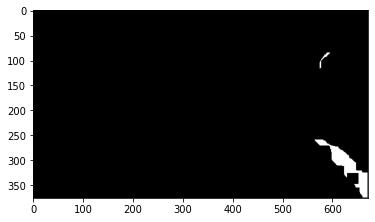

In [ ]:
import cv2
import matplotlib.pyplot as plt

a = cv2.imread('/content/FDA_Drone_Data/blender_airsim_aligned/Label_fromJSON/label_000009.png', 0)

label_forBCE = np.zeros((a.shape[0], a.shape[1], 3))
for i in range(label_forBCE.shape[0]):
    for j in range(label_forBCE.shape[1]):
        if a[i,j] == 1:
            label_forBCE[i,j,0] = 1
        elif a[i,j] == 2:
            label_forBCE[i,j,1] = 1
        elif a[i,j] == 3:
            label_forBCE[i,j,2] = 1

b= label_forBCE[:,:,1]
b[np.where(b==1)] = 255
plt.imshow(b, cmap='gray')

In [ ]:
label_forBCE[1,2] = np.array([1, 0, 0])

In [ ]:
label_forBCE.reshape(-1, 3)

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [ ]:
a = cv2.imread('/content/FDA_Drone_Data/blender_airsim_aligned/images/image_000001.png')

In [ ]:
a[0,0]

array([ 7, 69, 89], dtype=uint8)

In [ ]:
a

array([[[  7,  69,  89],
        [  6,  69,  88],
        [  8,  70,  90],
        ...,
        [ 18, 116, 144],
        [ 19, 115, 142],
        [ 20, 114, 142]],

       [[  7,  69,  88],
        [  6,  68,  88],
        [  8,  69,  89],
        ...,
        [ 20, 115, 143],
        [ 20, 115, 143],
        [ 20, 114, 141]],

       [[  7,  68,  88],
        [  7,  69,  89],
        [  7,  69,  89],
        ...,
        [ 18, 118, 145],
        [ 19, 117, 145],
        [ 20, 116, 144]],

       ...,

       [[  7,  41,  65],
        [  7,  40,  65],
        [  7,  41,  67],
        ...,
        [ 19, 114, 142],
        [ 19, 114, 142],
        [ 19, 114, 143]],

       [[  7,  42,  63],
        [  8,  42,  65],
        [  7,  42,  64],
        ...,
        [ 18, 115, 143],
        [ 18, 114, 142],
        [ 18, 114, 142]],

       [[  7,  44,  63],
        [  7,  42,  62],
        [  6,  41,  62],
        ...,
        [ 18, 114, 143],
        [ 19, 112, 141],
        [ 20, 113, 142]]

In [ ]:
a.reshape(-1,3)
print(a)

[[[  7  69  89]
  [  6  69  88]
  [  8  70  90]
  ...
  [ 18 116 144]
  [ 19 115 142]
  [ 20 114 142]]

 [[  7  69  88]
  [  6  68  88]
  [  8  69  89]
  ...
  [ 20 115 143]
  [ 20 115 143]
  [ 20 114 141]]

 [[  7  68  88]
  [  7  69  89]
  [  7  69  89]
  ...
  [ 18 118 145]
  [ 19 117 145]
  [ 20 116 144]]

 ...

 [[  7  41  65]
  [  7  40  65]
  [  7  41  67]
  ...
  [ 19 114 142]
  [ 19 114 142]
  [ 19 114 143]]

 [[  7  42  63]
  [  8  42  65]
  [  7  42  64]
  ...
  [ 18 115 143]
  [ 18 114 142]
  [ 18 114 142]]

 [[  7  44  63]
  [  7  42  62]
  [  6  41  62]
  ...
  [ 18 114 143]
  [ 19 112 141]
  [ 20 113 142]]]


In [ ]:
import torch
import torch.nn as nn
data_input=torch.Tensor([[0.3980, 0.8603, 0.1073]])#三分类问题，批大小为2.只有一个批。
data_target=torch.Tensor([[0,1,0]])#都属于类别1，属于哪个类别，该类别就是0.
loss=nn.BCELoss(reduction="none")
loss(data_input,data_target)



tensor([[0.5075, 0.1505, 0.1135]])

In [ ]:
a = cv2.imread('/content/FDA_Drone_Data/blender_airsim_aligned/Label_fromJSON/label_000009.png')
a[4,5]

array([0, 0, 0], dtype=uint8)

In [ ]:
a[4, 1] = np.array([1, 0, 0])

In [ ]:
a[4]

array([[0, 0, 0],
       [1, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=uint8)